In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from IPython.core.display import display, HTML
import os
import tempfile

from auxiliary import grids_skf_lr, grids_skf_lsvc, grids_skf_rf, grids_skf_svc, \
    grids_skf_xgb, plot_cm, plot_elbow_kmeans, plot_nn_metrics, plot_pr_curve, \
    plot_roc, save_metrics

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# Load of pre processed data
%run -i data_pre_proc.py

	2 columns, ['EmployeeCount', 'StandardHours'] were droped
	The ['Over18'] column was droped.
	Pattern " " cleared.
	Pattern "Travel_" cleared.
	Pattern "-" cleared.
	Pattern "&" cleared.
--------------------------------------------------------------------------
 Pre-processing concluded on  ../Data/HR_DS.csv with success.
 Dataframes produced: finaldf
 Other instances created: n_features
 ___________________________________________________________________________


# I. Introduction and Workflow
Our approach to the problem at hand is as follows in the next flowchart or pipeline. This was due, namely, to the fact that: 
1. The dataset is imbalanced;
2. There is no time dimension to the data available;
3. There is no great volume of data

First, the dataset will be split into 2 stratified sets of data so that the following is available:
* A train dataset (features and labels appart) (90%)
    * The models will be trained and validated on this subset;
    * For sake of reproducibility we will apply the same techniques in order to find the best performance model;
    * The best model(s) will be selected to train on this full data subset before being tested against the test dataset (as follows)
* A test dataset (features and labels appart) (10%)
    * This will be used to test the final models as an out-of-sample dataset.
    
After the selection of best model(s) there will be extracted feature importance by permutation and a cluster analysis/profiling.
The resulting insights will be used as an holistic advise on:
* Feature Improvement to avoid atritrion
* Attrition Prediction

In [3]:
display(HTML('../resources/modeling.html'))

# II. Models

## A. Settings and global instances

In [4]:
# test 10%; train 90%
train_df, test_df = train_test_split(finaldf, test_size=0.1, random_state=0, stratify=finaldf.Attrition_Yes)

# Initialization of min-max normalizing scaler
minmax = MinMaxScaler()

# Form np arrays of labels and features
train_labels = np.array(train_df.Attrition_Yes)
test_labels = np.array(test_df.Attrition_Yes)

# The train and test features will be normalized separatedly in order not to cross-contaminate data
train_features = train_df.drop('Attrition_Yes', axis=1)
test_features = minmax.fit_transform(test_df.drop('Attrition_Yes', axis=1))
train_features_norm = minmax.fit_transform(train_features)

# vectorize train features
train_features_v = np.array(train_features)

# initialization of the dataframe to store the metrics for each model evaluated on test split
m_summary = pd.DataFrame(columns=[
    'model','tp', 'fp', 'tn', 'fn', 
    'acc', 'prec', 'recall', 'pr_auc', 'f1', 'mc_coef', 
    'batch_s', 'data', 'series'
])

# standart number of folds to be used by StratifiedKfold sampling
n_folds = 10

print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)
print('')
print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (1323,)
Test labels shape: (147,)

Training features shape: (1323, 41)
Test features shape: (147, 41)


In [5]:
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

### A.1. Imbalanced Series (original weights)
A check on the imbalance of the datasets is needed as follows:

In [6]:
neg_df, pos_df = np.bincount(finaldf.Attrition_Yes)
total_df = neg_df + pos_df
neg_test, pos_test = np.bincount(test_labels)
total_test = neg_test + pos_test
neg_t, pos_t = np.bincount(train_labels)
total_t = neg_t + pos_t

print('Cases on full dataset:\n\tTotal: {}\n\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_df, pos_df, 100 * pos_df / total_df))
print('\tCases on test dataset:\n\t\tTotal: {}\n\t\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_test, pos_test, 100 * pos_test / total_test))
print('\tCases on training dataset:\n\t\tTotal: {}\n\t\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_t, pos_t, 100 * pos_t / total_t))

Cases on full dataset:
	Total: 1470
	Employees that Left the company: 237 (16.12% of total)

	Cases on test dataset:
		Total: 147
		Employees that Left the company: 24 (16.33% of total)

	Cases on training dataset:
		Total: 1323
		Employees that Left the company: 213 (16.10% of total)



A determination of the weights of the target label (train dataset) will be important further on the testing of the models

In [7]:
# Scaling by total/2(categories) helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg_t)*(total_t)/2
weight_for_1 = (1 / pos_t)*(total_t)/2

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (Stayers): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (Leavers): {:.2f}'.format(weight_for_1))

Weight for class 0 (Stayers): 0.60
Weight for class 1 (Leavers): 3.11


### A.2. Oversampled Series (SMOTE)
In order to minimize impact of the imbalance on the original dataset, We'll be using SMOTE to generate artificial data based on the k nearest neighbours of the train data subset.

In [8]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


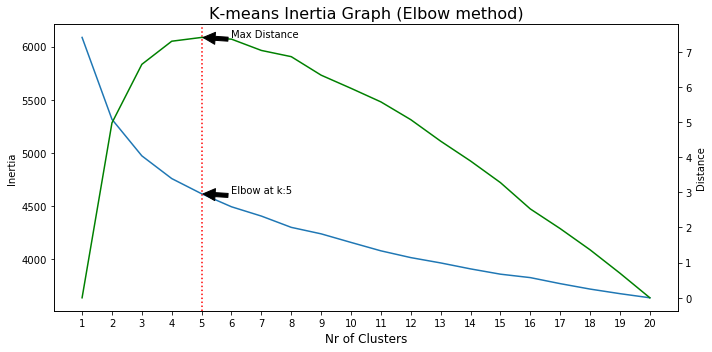

The best number of clusters is 5


In [9]:
n_kn = plot_elbow_kmeans(train_features_norm, 20)

In [10]:
smote = SMOTE(
    k_neighbors=n_kn,
    random_state=0,
    n_jobs=-1
)

In [11]:
# producing the data subset oversampled
X_SMOTE, y_SMOTE = smote.fit_sample(train_features_norm, train_labels)

X_SMOTE_mm = minmax.fit_transform(X_SMOTE)

This data subset will have equal weights for both classes of the target labels. In this case the artificial data produced belong to class '1', the employees who have left the company (Attrition = Yes)

## 1. XGBoost

### 1.1. Imbalanced Series

#### 1.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [12]:
# fit model on training data
parameters_XGB = {
    'objective':['binary:logistic'],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [i for i in range(3,7)],
    'subsample': [0.5, 1],
    'colsample_bytree': [0.5, 1],
    'n_estimators': [100, 1000, 2000],
    'seed': [123]}

model_XGB = grids_skf_xgb(
    train_features,
    train_labels, 
    parameters_XGB, 
    pos_t/neg_t, 
    n_folds
)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.9min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.1918918918918919,
              seed=123, silent=None, subsample=0.5, verbosity=0)


#### 1.1.2. Evaluation - Stratified K-Fold CV

In [13]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_XGB.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_XGB', ytrain, model_XGB.predict_proba(xtrain)[:, 1], split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_XGB', yval, model_XGB.predict_proba(xval)[:, 1], split_data='val', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_XGB', test_labels, model_XGB.predict_proba(test_features)[:, 1], split_data='test', series='imbalanced')
print('...Done')

Training on fold 1/10...
Training on fold 2/10...
Training on fold 3/10...
Training on fold 4/10...
Training on fold 5/10...
Training on fold 6/10...
Training on fold 7/10...
Training on fold 8/10...
Training on fold 9/10...
Training on fold 10/10...
...Done


### 1.2. Oversampling Series

#### 1.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [14]:
# fit model on training data
model_XGB_smote = grids_skf_xgb(
    X_SMOTE_mm,
    y_SMOTE, 
    parameters_XGB, 
    n_folds
)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  4.9min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, seed=123,
              silent=None, subsample=0.5, verbosity=0)


#### 1.2.2. Evaluation - Stratified K-Fold CV

In [15]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    
    # train model
    model_XGB_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(m_summary, 'model_XGB', ytrain_SMOTE, model_XGB_smote.predict_proba(xtrain_SMOTE)[:, 1], split_data='train', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_XGB', yval, model_XGB_smote.predict_proba(xval)[:, 1], split_data='val', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_XGB', test_labels, model_XGB_smote.predict_proba(test_features)[:, 1], split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 2/10...
Training on fold 3/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 4/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 5/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 6/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 7/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 8/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 9/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 10/10...
...Done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


## 2. Logistic Regression

### 2.1. Imbalanced Series

#### 2.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [16]:
parameters_log = [{
    'solver' : ['sag'],
    'C' : [1, 10, 100],
    'max_iter': [10000],
    'penalty' : ('none', 'l2'),
    'warm_start' : (True, False),
    'fit_intercept' : [True, False]
},{
    'solver' : ['liblinear', 'saga'], 
    'C' : [1, 10, 100],
    'max_iter': [10000],
    'penalty' : ('l1', 'l2'),
    'warm_start' : (True, False),
    'fit_intercept' : [True, False]
}]

model_logistic = grids_skf_lr(
    train_features,
    train_labels, 
    parameters_log, 
    class_weights, 
    n_folds
)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 594 tasks      | elapsed:   28.1s


LogisticRegression(C=1,
                   class_weight={0: 0.595945945945946, 1: 3.1056338028169015},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=10000, multi_class='ovr', n_jobs=-1,
                   penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=True)


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


#### 2.1.2. Evaluation - Stratified K-Fold CV

In [17]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_logistic.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_logistic', ytrain, model_logistic.predict_proba(xtrain)[:, 1], split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_logistic', yval, model_logistic.predict_proba(xval)[:, 1], split_data='val', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_logistic', test_labels, model_logistic.predict_proba(test_features)[:, 1], split_data='test', series='imbalanced')
print('...Done')

Training on fold 1/10...
Training on fold 2/10...
Training on fold 3/10...
Training on fold 4/10...
Training on fold 5/10...

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Training on fold 6/10...
Training on fold 7/10...
Training on fold 8/10...
Training on fold 9/10...

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Training on fold 10/10...
...Done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


### 2.2. Oversampling Series

#### 2.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [18]:
model_logistic_smote = grids_skf_lr(
    X_SMOTE_mm,
    y_SMOTE, 
    parameters_log,
    {0: 1, 1: 1},
    n_folds
)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 519 tasks      | elapsed:   28.3s


LogisticRegression(C=1, class_weight={0: 1, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='ovr', n_jobs=-1, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=True)


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   40.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


#### 2.2.2. Evaluation - Stratified K-Fold CV

In [19]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    
    # train model
    model_logistic_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(m_summary, 'model_logistic', ytrain_SMOTE, model_logistic.predict_proba(xtrain_SMOTE)[:, 1], split_data='train', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_logistic', yval, model_logistic.predict_proba(xval)[:, 1], split_data='val', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_logistic', test_labels, model_logistic.predict_proba(test_features)[:, 1], split_data='test', series='SMOTE')
print('...Done')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Training on fold 1/10...
Training on fold 2/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 3/10...

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Training on fold 4/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 5/10...
Training on fold 6/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 7/10...
Training on fold 8/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 9/10...
Training on fold 10/10...
...Done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


## 3. LinearSVC

### 3.1. Imbalanced Series

#### 3.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [20]:
parameters_lsvc = [{
    'C' : [i for i in range(1,10,2)],
    'penalty' : ['l1', 'l2'],
    'max_iter': [10000, 100000, 1000000]
}]

model_LinearSVC = grids_skf_lsvc(
    train_features, 
    train_labels, 
    parameters_lsvc, 
    class_weights, 
    n_folds
)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   16.1s finished


LinearSVC(C=1, class_weight={0: 0.595945945945946, 1: 3.1056338028169015},
          dual=False, fit_intercept=True, intercept_scaling=1,
          loss='squared_hinge', max_iter=10000, multi_class='ovr', penalty='l1',
          random_state=0, tol=0.0001, verbose=0)


#### 3.1.2. Evaluation - Stratified K-Fold CV

In [21]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_LinearSVC.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_LinearSVC', ytrain, model_LinearSVC.decision_function(xtrain), split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_LinearSVC', yval, model_LinearSVC.decision_function(xval), split_data='val', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_LinearSVC', test_labels, model_LinearSVC.decision_function(test_features), split_data='test', series='imbalanced')
print('...Done')

Training on fold 1/10...
Training on fold 2/10...
Training on fold 3/10...
Training on fold 4/10...
Training on fold 5/10...
Training on fold 6/10...
Training on fold 7/10...
Training on fold 8/10...
Training on fold 9/10...
Training on fold 10/10...
...Done


### 3.2. Oversampling Series

#### 3.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [22]:
model_LinearSVC_smote = grids_skf_lsvc(
    X_SMOTE_mm, 
    y_SMOTE, 
    parameters_lsvc,
    {0: 1, 1: 1},
    n_folds
)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   13.3s


LinearSVC(C=3, class_weight={0: 1, 1: 1}, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.2s finished


#### 3.2.2. Evaluation - Stratified K-Fold CV

In [23]:
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    
    # train model
    model_LinearSVC_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(m_summary, 'model_LinearSVC', ytrain_SMOTE, model_LinearSVC_smote.decision_function(xtrain_SMOTE), split_data='train', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_LinearSVC', yval, model_LinearSVC_smote.decision_function(xval), split_data='val', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_LinearSVC', test_labels, model_LinearSVC_smote.decision_function(test_features), split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/10...
Training on fold 2/10...

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)



Training on fold 3/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 4/10...
Training on fold 5/10...
Training on fold 6/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 7/10...
Training on fold 8/10...
Training on fold 9/10...
Training on fold 10/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


...Done


## 4. SVC

### 4.1. Imbalanced Series

#### 4.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [24]:
parameters_svc = [{
    'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'],
    'C' : [i for i in range(1,10,2)],
    'gamma' : [1, 0.1],
    'coef0' : [1, 0.1],
    'shrinking' : [True, False]
}]

model_SVC = grids_skf_svc(
    train_features,
    train_labels,
    parameters_svc,
    class_weights,
    n_folds
)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=1, cache_size=200,
    class_weight={0: 0.595945945945946, 1: 3.1056338028169015}, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=5000, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


#### 4.1.2. Evaluation - Stratified K-Fold CV

In [26]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_SVC.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_SVC', ytrain, model_SVC.predict_proba(xtrain)[:, 1], split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_SVC', yval, model_SVC.predict_proba(xval)[:, 1], split_data='val', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_SVC', test_labels, model_SVC.predict_proba(test_features)[:, 1], split_data='test', series='imbalanced')
print('...Done')

Training on fold 1/10...
Training on fold 2/10...
Training on fold 3/10...
Training on fold 4/10...
Training on fold 5/10...
Training on fold 6/10...
Training on fold 7/10...
Training on fold 8/10...
Training on fold 9/10...
Training on fold 10/10...
...Done


### 4.2. Oversampling Series

#### 4.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [27]:
model_SVC_smote = grids_skf_svc(
    X_SMOTE_mm,
    y_SMOTE,
    parameters_svc,
    {0: 1, 1: 1},
    n_folds
)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  3.9min finished


SVC(C=3, cache_size=200, class_weight={0: 1, 1: 1}, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
    max_iter=5000, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


#### 4.2.2. Evaluation - Stratified K-Fold CV

In [28]:
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)

    # train model
    model_SVC_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(m_summary, 'model_SVC', ytrain_SMOTE, model_SVC_smote.predict_proba(xtrain_SMOTE)[:, 1], split_data='train', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_SVC', yval, model_SVC_smote.predict_proba(xval)[:, 1], split_data='val', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_SVC', test_labels, model_SVC_smote.predict_proba(test_features)[:, 1], split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 2/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 3/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 4/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 5/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 6/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-def

Training on fold 7/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 8/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 9/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 10/10...
...Done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


## 5. Random Forest Classifier

### 5.1. Imbalanced Series

#### 5.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [29]:
parameters_rf = [{
    'n_estimators' : [100, 500, 1000],
    'max_depth' : [i for i in range(3,15,3)],
    'min_samples_split' : [i for i in range (2,4)],
    'min_samples_leaf' : [i for i in range (2,4)]
}]

model_RandomForest = grids_skf_rf(
    train_features, 
    train_labels, 
    parameters_rf, 
    class_weights, 
    n_folds
)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.7min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.595945945945946,
                                     1: 3.1056338028169015},
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)


#### 5.1.2. Evaluation - Stratified K-Fold CV

In [31]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_RandomForest.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_RandomForest', ytrain, model_RandomForest.predict_proba(xtrain)[:, 1], split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_RandomForest', yval, model_RandomForest.predict_proba(xval)[:, 1], split_data='val', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_RandomForest', test_labels, model_RandomForest.predict_proba(test_features)[:, 1], split_data='test', series='imbalanced')
print('...Done')

Training on fold 1/10...
Training on fold 2/10...
Training on fold 3/10...
Training on fold 4/10...
Training on fold 5/10...
Training on fold 6/10...
Training on fold 7/10...
Training on fold 8/10...
Training on fold 9/10...
Training on fold 10/10...
...Done


### 5.2. Oversampling Series

#### 5.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [32]:
model_RandomForest_smote = grids_skf_rf(
    X_SMOTE_mm, 
    y_SMOTE, 
    parameters_rf, 
    {0: 1, 1: 1}, 
    n_folds
)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.2min finished


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)


#### 5.2.2. Evaluation - Stratified K-Fold CV

In [33]:
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    
    # train model
    model_RandomForest_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(m_summary, 'model_RandomForest', ytrain_SMOTE, model_RandomForest_smote.predict_proba(xtrain_SMOTE)[:, 1], split_data='train', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_RandomForest', yval, model_RandomForest_smote.predict_proba(xval)[:, 1], split_data='val', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_RandomForest', test_labels, model_RandomForest_smote.predict_proba(test_features)[:, 1], split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 2/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 3/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 4/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 5/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 6/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 7/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 8/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 9/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 10/10...
...Done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


## 6. Keras Tensorflow Classification Deep Neural Network

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [35]:
#metrics to obtain in history
METRICS = [
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.Accuracy(name='acc'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
]

# max number of epochs (the early stopping callback will cutoff before)
EPOCHS = 100 
#best batch size = 64, 70, 32, 128, 256
BATCH_SIZE = 32

# Defining specific callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=0,
    patience=20, #best 20
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,
    patience=5,
    cooldown=6,
    min_lr=0.00001
)

callback = [
    early_stopping,
    reduce_lr
]

if n_features%2 == 0:
    n_init_neurons = n_features
else:
    n_init_neurons = n_features+1
    
print('The advisable number of neurons in the first layer should be: ', n_init_neurons)

The advisable number of neurons in the first layer should be:  42


Constructor of Keras model definition

In [36]:
def make_model(
    metrics = METRICS,
    output_bias = None, 
    learn_rate = 0.001, 
    l1_neurons = n_init_neurons, 
    l2_neurons = 24, 
    input_shape = train_features.shape[-1:], 
    l2_dropout = 0.25
):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    model = Sequential(
        [
            #First hidden layer
        Dense(
            l1_neurons, 
            activation=keras.layers.ELU(), 
            input_shape=input_shape,
            name='first_hidden_layer'
        ),
            #Normalization layer
        BatchNormalization(name='first_Batch_norm'),
            #Second hidden layer
        Dense(
            l2_neurons,
            activation=keras.layers.LeakyReLU(),
            name='second_hidden_layer'
        ),
            #Normalization layer
        BatchNormalization(name='second_Batch_norm'),
            #Dropout layer
        Dropout(
            l2_dropout,
            name='l2_dropout_layer'
        ),
            #Output layer
        Dense(
            1, 
            activation='sigmoid',                   # sigmoid for regressor with probability output
            bias_initializer=output_bias,
            name='output_layer'
        )
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=learn_rate),
            #Optimizer to use
            #optimizer_ = keras.optimizers.RMSprop(lr=learn_rate)
            #optimizer=keras.optimizers.Nadam(lr=learn_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

In [37]:
make_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_hidden_layer (Dense)   (None, 42)                1764      
_________________________________________________________________
first_Batch_norm (BatchNorma (None, 42)                168       
_________________________________________________________________
second_hidden_layer (Dense)  (None, 24)                1032      
_________________________________________________________________
second_Batch_norm (BatchNorm (None, 24)                96        
_________________________________________________________________
l2_dropout_layer (Dropout)   (None, 24)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 25        
Total params: 3,085
Trainable params: 2,953
Non-trainable params: 132
____________________________________________________

### 6.1. Imbalanced Series

#### 6.1.1. Optimization - Bayesian Optimization on weighted model

Bayesian Optimization on the train dataset to better tune hyperparameters on the model.

Defining black box function

In [38]:
def fit_with(
    learn_rate, 
    l1_neurons, 
    l2_neurons, 
    l2_dropout,
    BATCH_SIZE,
    X = train_features,
    y = train_labels
):
    X = np.array(train_features)
    y = train_labels
    # Split of data for evaluation (random state defined)
    X, X_val, y, y_val = train_test_split(X, y, stratify=y, random_state=0, test_size=0.1)
    # Instatiate model
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(y)
    initial_bias = np.log([pos_nn/neg_nn])
    
    # Discretize parameters
    l1_neurons = max(int(l1_neurons)*2, 32)
    l2_neurons = max(int(l2_neurons)*2, 2)
    BATCH_SIZE = max(int(BATCH_SIZE)*64, 32)
    
    model_keras_opt = make_model(
        metrics = METRICS,
        output_bias = initial_bias,
        learn_rate = 0.001,
        l1_neurons = n_init_neurons,
        l2_neurons = 24,
        input_shape = X.shape[-1:],
        l2_dropout = 0.25
    )
    
    results = model_keras_opt.evaluate(minmax.fit_transform(X_val), y_val, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_opt.save_weights(initial_weights)
    
    # Trainning of the model on the training features
    model_keras_opt.fit(
        minmax.fit_transform(X),
        y,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks = callback,
        validation_data=(minmax.fit_transform(X_val), y_val),
        class_weight=class_weights,
        verbose=0
    )
    
    # Evaluation of model with validation data
    scores = model_keras_opt.evaluate(
        x=X_val, 
        y=y_val,
        verbose=0
    )
        
    tn = scores[5]
    tp = scores[6]
    fn = scores[7]
    fp = scores[8]
    numerator = (tp * tn + fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) + 1e-7
    mc_coef = numerator / denominator
    # The target score to maximize, in this case we think the best is mcc
    return mc_coef

In [39]:
from functools import partial
fit_with_partial = partial(fit_with)

In [40]:
from bayes_opt import BayesianOptimization

In [ ]:
p_bounds = {
    'learn_rate':(1e-4, 1e-1), 
    'l1_neurons':(16, 42), # max(int(i)*2, 32)
    'l2_neurons':(1, 14), # max(int(i)*2, 2)
    'l2_dropout':(0, 0.8),
    'BATCH_SIZE':(0.5, 4.6), # max(int(i)*64, 32)
}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=p_bounds,
    verbose=1,
    random_state=0
)

optimizer.maximize(
    init_points=10,
    n_iter=100
)

#for i, res in enumerate(optimizer.res):
#    print('Iteration {}: \n\t{}'.format(i, res))

|   iter    |  target   | BATCH_... | l1_neu... | l2_dro... | l2_neu... | learn_... |
-------------------------------------------------------------------------------------
|  4        |  0.3504   |  0.8572   |  16.53    |  0.6661   |  11.12    |  0.08701  |
|  10       |  0.3842   |  3.25     |  21.47    |  0.1031   |  5.101    |  0.03643  |
|  24       |  0.3849   |  4.6      |  16.0     |  0.0      |  3.735    |  0.1      |
|  54       |  0.3888   |  4.6      |  28.21    |  0.0      |  1.0      |  0.1      |
|  74       |  0.3999   |  0.5      |  18.85    |  0.0      |  1.0      |  0.1      |


In [ ]:
print('learn_rate:', optimizer.max['params']['learn_rate'])
print('l1_neurons:', max(int(optimizer.max['params']['l1_neurons'])*2, 32))
print('l2_neurons:', max(int(optimizer.max['params']['l2_neurons'])*2, 2))
print('l2_dropout:', optimizer.max['params']['l2_dropout'])
print('BATCH_SIZE:', max(int(optimizer.max['params']['BATCH_SIZE'])*64, 32))

In [ ]:
import time
timestamp = time.gmtime()

with open('../logs/nn_opt_log.txt', 'a') as file:
    file.write(str(timestamp) + '\n')
    file.write('imbalanced: ' + str(optimizer.max) + '\n')
    file.write('---------------------------------------------------------------- \n')
file.close()

In [ ]:
learn_rate = optimizer.max['params']['learn_rate']
l1_neurons = max(int(optimizer.max['params']['l1_neurons'])*2, 32)
l2_neurons = max(int(optimizer.max['params']['l2_neurons'])*2, 2)
l2_dropout = optimizer.max['params']['l2_dropout']
BATCH_SIZE = max(int(optimizer.max['params']['BATCH_SIZE'])*64, 32)

tf.keras.backend.clear_session()

#### 6.1.2. Evaluation - Stratified K-Fold CV

In [ ]:
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

train_feat_norm = minmax.fit_transform(train_features)

model_keras_w_history = []
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    
    # Generate batches from indices
    X, X_val = train_feat_norm[train_indices], train_feat_norm[val_indices]
    y, y_val = train_labels[train_indices], train_labels[val_indices]
    
    # Clear model
    model_keras_w = None
    
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(ytrain)
    initial_bias = np.log([pos_nn/neg_nn])
    
    model_keras_w = make_model(
        metrics = METRICS,
        output_bias = initial_bias,
        learn_rate = learn_rate,
        l1_neurons = l1_neurons,
        l2_neurons = l2_neurons,
        input_shape = X.shape[-1:],
        l2_dropout = l2_dropout
    )
    
    results = model_keras_w.evaluate(xtrain, ytrain, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_w.save_weights(initial_weights)

    baseline_history = model_keras_w.fit(
        X,
        y,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = callback,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        verbose=0)
    
    model_keras_w_history.append(baseline_history)
    m_summary = save_metrics(m_summary, 'NN_weighted', ytrain, model_keras_w.predict_proba(xtrain), batch_size=BATCH_SIZE, split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'NN_weighted', yval, model_keras_w.predict_proba(xval), batch_size=BATCH_SIZE, split_data='val', series='imbalanced')
    m_summary = save_metrics(m_summary, 'NN_weighted', test_labels, model_keras_w.predict_proba(test_features), batch_size=BATCH_SIZE, split_data='test', series='imbalanced')
print('...Done')

tf.keras.backend.clear_session()

In [ ]:
for i, h in enumerate(model_keras_w_history):
    print('Metrics for fold nr:', i+1)
    plot_nn_metrics(h)

In [ ]:
test_predictions_weighted = model_keras_w.predict_proba(test_features, batch_size=BATCH_SIZE)

### 6.2. Oversampling Series

#### 6.2.1. Optimization - Bayesian Optimization on weighted model

In [ ]:
def fit_with_smote(
    learn_rate, 
    l1_neurons, 
    l2_neurons, 
    l2_dropout,
    BATCH_SIZE,
    X = X_SMOTE_mm,
    y = y_SMOTE
):
    X = np.array(train_features)
    y = train_labels
    # Split of data for evaluation (random state defined)
    X, X_val, y, y_val = train_test_split(X, y, stratify=y, random_state=0, test_size=0.1)
    # Instatiate model
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(y)
    initial_bias = np.log([pos_nn/neg_nn])
    
    # Discretize parameters
    l1_neurons = max(int(l1_neurons)*2, 32)
    l2_neurons = max(int(l2_neurons)*2, 2)
    BATCH_SIZE = max(int(BATCH_SIZE)*64, 32)
    
    model_keras_opt_smote = make_model(
        metrics = METRICS,
        output_bias = initial_bias,
        learn_rate = 0.001,
        l1_neurons = n_init_neurons,
        l2_neurons = 24,
        input_shape = X.shape[-1:],
        l2_dropout = 0.25
    )
    
    results = model_keras_opt_smote.evaluate(minmax.fit_transform(X_val), y_val, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_opt_smote.save_weights(initial_weights)
    
    # Trainning of the model on the training features
    model_keras_opt_smote.fit(
        minmax.fit_transform(X),
        y,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks = callback,
        validation_data=(minmax.fit_transform(X_val), y_val),
        verbose=0
    )
    
    # Evaluation of model with validation data
    scores = model_keras_opt_smote.evaluate(
        x=X_val, 
        y=y_val,
        verbose=0
    )
    
    tn = scores[5]
    tp = scores[6]
    fn = scores[7]
    fp = scores[8]
    numerator = (tp * tn + fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) + 1e-7
    mc_coef = numerator / denominator
    # The target score to maximize, in this case we think the best is mcc
    return mc_coef

In [ ]:
fit_with_partial_smote = partial(fit_with_smote)

optimizer_smote = BayesianOptimization(
    f=fit_with_partial_smote,
    pbounds=p_bounds,
    verbose=1,
    random_state=0
)

optimizer_smote.maximize(
    init_points=10,
    n_iter=100
)

#for i, res in enumerate(optimizer.res):
#    print('Iteration {}: \n\t{}'.format(i, res))

print('learn_rate:', optimizer_smote.max['params']['learn_rate'])
print('l1_neurons:', max(int(optimizer_smote.max['params']['l1_neurons'])*2, 32))
print('l2_neurons:', max(int(optimizer_smote.max['params']['l2_neurons'])*2, 2))
print('l2_dropout:', optimizer_smote.max['params']['l2_dropout'])
print('BATCH_SIZE:', max(int(optimizer_smote.max['params']['BATCH_SIZE'])*64, 32))

In [ ]:
import time
timestamp = time.gmtime()

with open('../logs/nn_opt_log.txt', 'a') as file:
    file.write(str(timestamp) + '\n')
    file.write('smote: ' + str(optimizer_smote.max) + '\n')
    file.write('---------------------------------------------------------------- \n')
file.close()

In [ ]:
learn_rate = optimizer_smote.max['params']['learn_rate']
l1_neurons = max(int(optimizer_smote.max['params']['l1_neurons'])*2, 32)
l2_neurons = max(int(optimizer_smote.max['params']['l2_neurons'])*2, 2)
l2_dropout = optimizer_smote.max['params']['l2_dropout']
BATCH_SIZE = max(int(optimizer_smote.max['params']['BATCH_SIZE'])*64, 32)

tf.keras.backend.clear_session()

#### 6.2.2. Evaluation - Stratified K-Fold CV

In [ ]:
model_keras_smote_history = []
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    
    # Clear model
    model_keras_smote = None
    
    #Loss with correct initialization and saving of bias onto model
    #neg_nn, pos_nn = np.bincount(ytrain_SMOTE)
    #initial_bias = np.log([pos_nn/neg_nn])
    model_keras_smote = make_model()#output_bias = initial_bias)
    #results = model_keras_smote.evaluate(xtrain, ytrain, batch_size=BATCH_SIZE, verbose=0)
    #initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    #model_keras_smote.save_weights(initial_weights)

    baseline_history_smote = model_keras_smote.fit(
        xtrain_SMOTE,
        ytrain_SMOTE,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = callback,
        validation_data=(xval, yval),
        verbose=0)
    
    # Debug message
    # print "Training new iteration on " + str(xtrain.shape[0]) + " training samples, " + str(xval.shape[0]) + " validation samples, this may be a while..."
    
    model_keras_smote_history.append(baseline_history_smote)
    m_summary = save_metrics(m_summary, 'NN_weighted', ytrain_SMOTE, model_keras_smote.predict_proba(xtrain_SMOTE), batch_size=BATCH_SIZE, split_data='train', series='SMOTE')
    m_summary = save_metrics(m_summary, 'NN_weighted', yval, model_keras_smote.predict_proba(xval), batch_size=BATCH_SIZE, split_data='val', series='SMOTE')
    m_summary = save_metrics(m_summary, 'NN_weighted', test_labels, model_keras_smote.predict_proba(test_features), batch_size=BATCH_SIZE, split_data='test', series='SMOTE')
print('...Done')

In [ ]:
for i, h in enumerate(model_keras_smote_history):
    print('Metrics for fold nr:', i+1)
    plot_nn_metrics(h)

# ...

# III. Selecting Best Models

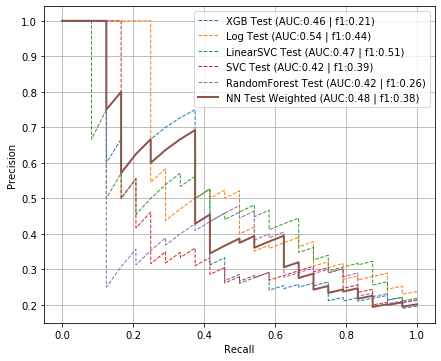

In [49]:
plt.figure(figsize=(7, 7))
plot_pr_curve("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], model_XGB.predict(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_pr_curve("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], model_logistic.predict(test_features), lcolor=colors[1], lstyle='--', lwidth=1)

plot_pr_curve("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), model_LinearSVC.predict(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_pr_curve("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], model_SVC.predict(test_features), lcolor=colors[3], lstyle='--', lwidth=1)

plot_pr_curve("RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], model_RandomForest.predict(test_features), lcolor=colors[4], lstyle='--', lwidth=1)

plot_pr_curve("NN Test Weighted", test_labels, test_predictions_weighted, model_keras_w.predict_classes(test_features, batch_size=BATCH_SIZE), lcolor=colors[5], lstyle='-')

plt.legend(loc='upper right')
plt.show()

In [50]:
m_summary.groupby(['model', 'data', 'series']).mean().sort_values(by=['mc_coef', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

acc  prec  recall  pr_auc    f1  \
model              data  series                                         
model_XGB          train imbalanced  0.99  1.00    0.91    1.00  0.95   
model_RandomForest train imbalanced  0.94  0.83    0.82    0.90  0.82   
NN_weighted        val   imbalanced  0.86  0.58    0.72    0.74  0.62   
                   train imbalanced  0.86  0.57    0.74    0.73  0.62   
model_LinearSVC    train imbalanced  0.88  0.70    0.47    0.65  0.56   
model_SVC          val   imbalanced  0.88  0.73    0.38    0.59  0.50   
model_logistic     train imbalanced  0.78  0.41    0.81    0.65  0.54   
model_LinearSVC    val   imbalanced  0.87  0.63    0.39    0.58  0.48   
model_RandomForest val   imbalanced  0.85  0.55    0.46    0.53  0.50   
model_XGB          val   imbalanced  0.87  0.75    0.28    0.55  0.40   
model_logistic     val   imbalanced  0.75  0.37    0.75    0.59  0.49   
model_SVC          train imbalanced  0.86  0.66    0.30    0.53  0.41   
model_logistic     test  imbalanced  0.77  0.38    0.61    0.48  0.47   
model_SVC          test  imbalanced  0.85  0.72    0.18    0.47  0.29   
model_XGB          test  imbalanced  0.85  0.72    0.18    0.45  0.28   
NN_weighted        test  imbalanced  0.81  0.46    0.38    0.46  0.38   
model_LinearSVC    test  imbalanced  0.84  0.54    0.19    0.47  0.28   
model_RandomForest test  imbalanced  0.80  0.34    0.20    0.40  0.25   

                                     mc_coef  batch_s  
model              data  series                        
model_XGB          train imbalanced     0.95      NaN  
model_RandomForest train imbalanced     0.79      NaN  
NN_weighted        val   imbalanced     0.56    192.0  
                   train imbalanced     0.56    192.0  
model_LinearSVC    train imbalanced     0.51      NaN  
model_SVC          val   imbalanced     0.47      NaN  
model_logistic     train imbalanced     0.46      NaN  
model_LinearSVC    val   imbalanced     0.43      NaN  
model_RandomForest val   imbalanced     0.42      NaN  
model_XGB          val   imbalanced     0.40      NaN  
model_logistic     val   imbalanced     0.39      NaN  
model_SVC          train imbalanced     0.38      NaN  
model_logistic     test  imbalanced     0.35      NaN  
model_SVC          test  imbalanced     0.31      NaN  
model_XGB          test  imbalanced     0.31      NaN  
NN_weighted        test  imbalanced     0.29    192.0  
model_LinearSVC    test  imbalanced     0.25      NaN  
model_RandomForest test  imbalanced     0.16      NaN

In [75]:
m_summary.to_csv('../logs/metrics_summary.csv')

In [76]:
m_summary.groupby(['model', 'data', 'series']).mean().sort_values(by=['mc_coef', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

acc  prec  recall  pr_auc    f1  \
model              data  series                                         
model_XGB          train SMOTE       1.00  1.00    1.00    1.00  1.00   
model_RandomForest train SMOTE       0.99  1.00    0.98    1.00  0.99   
model_XGB          train imbalanced  0.99  1.00    0.91    1.00  0.95   
model_SVC          train SMOTE       0.90  0.90    0.90    0.93  0.90   
model_RandomForest train imbalanced  0.94  0.83    0.82    0.90  0.82   
NN_weighted        val   imbalanced  0.86  0.58    0.72    0.74  0.62   
                   train imbalanced  0.86  0.57    0.74    0.73  0.62   
model_LinearSVC    train SMOTE       0.73  0.91    0.51    0.88  0.65   
                         imbalanced  0.88  0.70    0.47    0.65  0.56   
model_SVC          val   imbalanced  0.88  0.73    0.38    0.59  0.50   
model_logistic     train imbalanced  0.78  0.41    0.81    0.65  0.54   
model_XGB          val   SMOTE       0.86  0.60    0.46    0.59  0.51   
model_LinearSVC    val   SMOTE       0.86  0.61    0.44    0.59  0.51   
                         imbalanced  0.87  0.63    0.39    0.58  0.48   
model_RandomForest val   imbalanced  0.85  0.55    0.46    0.53  0.50   
model_XGB          val   imbalanced  0.87  0.75    0.28    0.55  0.40   
model_logistic     val   imbalanced  0.75  0.37    0.75    0.59  0.49   
model_RandomForest val   SMOTE       0.87  0.75    0.26    0.57  0.39   
model_SVC          train imbalanced  0.86  0.66    0.30    0.53  0.41   
model_logistic     test  imbalanced  0.77  0.38    0.61    0.48  0.47   
                         SMOTE       0.76  0.36    0.58    0.54  0.44   
model_SVC          test  imbalanced  0.85  0.72    0.18    0.47  0.29   
model_XGB          test  imbalanced  0.85  0.72    0.18    0.45  0.28   
NN_weighted        test  imbalanced  0.81  0.46    0.38    0.46  0.38   
model_LinearSVC    test  imbalanced  0.84  0.54    0.19    0.47  0.28   
model_RandomForest test  imbalanced  0.80  0.34    0.20    0.40  0.25   
NN_weighted        train SMOTE       0.56  0.70    0.26    0.63  0.31   
                   val   SMOTE       0.75  0.34    0.23    0.26  0.18   
model_LinearSVC    test  SMOTE       0.21  0.17    1.00    0.38  0.29   
model_RandomForest test  SMOTE       0.26  0.17    0.94    0.28  0.29   
NN_weighted        test  SMOTE       0.50  0.15    0.56    0.17  0.22   
model_XGB          test  SMOTE       0.16  0.16    1.00    0.28  0.28   
model_logistic     train SMOTE       0.50  0.50    1.00    0.75  0.67   
                   val   SMOTE       0.16  0.16    1.00    0.58  0.28   
model_SVC          test  SMOTE       0.84  0.00    0.00    0.58  0.00   
                   val   SMOTE       0.84  0.00    0.00    0.58  0.00   

                                     mc_coef  batch_s  
model              data  series                        
model_XGB          train SMOTE          1.00      NaN  
model_RandomForest train SMOTE          0.98      NaN  
model_XGB          train imbalanced     0.95      NaN  
model_SVC          train SMOTE          0.80      NaN  
model_RandomForest train imbalanced     0.79      NaN  
NN_weighted        val   imbalanced     0.56    192.0  
                   train imbalanced     0.56    192.0  
model_LinearSVC    train SMOTE          0.51      NaN  
                         imbalanced     0.51      NaN  
model_SVC          val   imbalanced     0.47      NaN  
model_logistic     train imbalanced     0.46      NaN  
model_XGB          val   SMOTE          0.44      NaN  
model_LinearSVC    val   SMOTE          0.44      NaN  
                         imbalanced     0.43      NaN  
model_RandomForest val   imbalanced     0.42      NaN  
model_XGB          val   imbalanced     0.40      NaN  
model_logistic     val   imbalanced     0.39      NaN  
model_RandomForest val   SMOTE          0.39      NaN  
model_SVC          train imbalanced     0.38      NaN  
model_logistic     test  imbalanced     0.35      NaN  
                         SMOTE 

In [77]:
m_summary_melted = pd.melt(
    m_summary, 
    id_vars=['model', 'data', 'series'], 
    value_vars=[
        'tp', 'fp', 'tn', 'fn', 
        'acc', 'prec', 'recall', 'pr_auc', 'f1', 'mc_coef'
    ], 
    var_name='metrics', 
    value_name='values')

m_summary_melted.to_csv('../logs/metrics_summary_melted.csv')

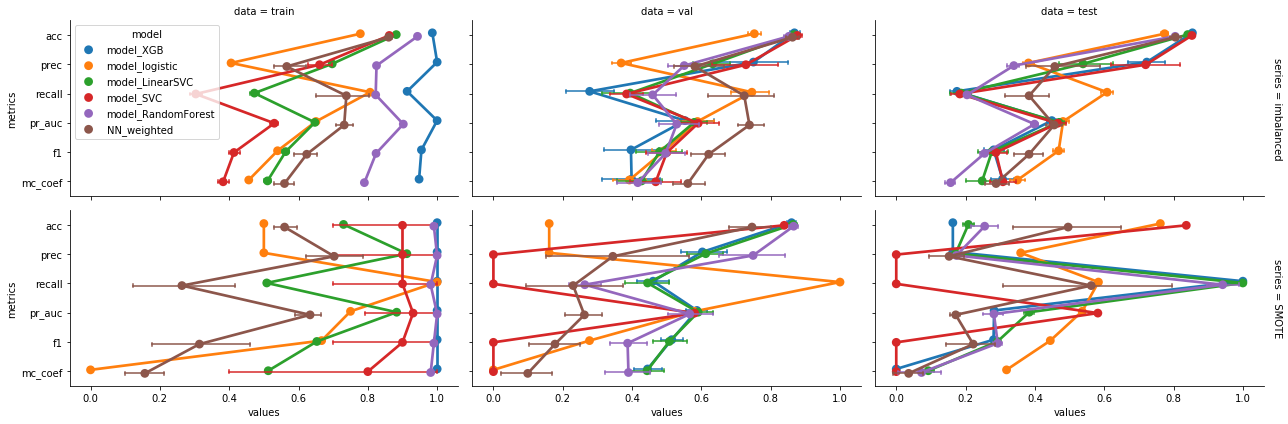

In [92]:
sb.catplot(
    x='values',
    y='metrics',
    hue='model',
    data=m_summary_melted[m_summary_melted.metrics.isin(['acc', 'prec', 'recall', 'pr_auc', 'f1', 'mc_coef'])], 
    row='series', 
    col='data',
    estimator= np.mean,
    ci=95, 
    n_boot=1000, 
    kind='point', 
    height=3,
    aspect=2, 
    palette='tab10', 
    legend=True, 
    legend_out=False, 
    sharex=True, 
    sharey=True, 
    margin_titles=True, 
    **{
        #'linestyles':'',
        'dodge':True,
        'capsize':0.1,
        'errwidth':1.5
    }
)
plt.tight_layout()
plt.show()

## 1. Feature importance

### D.1 Logistic Model

In [81]:
from scipy import stats
params = np.append(model_logistic.intercept_,model_logistic.coef_)
predictions = model_logistic.predict(test_features)

newX = pd.DataFrame({"Constant":np.ones(len(test_features))}).join(pd.DataFrame(test_features))
MSE = (sum((test_labels-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["features"],myDF3["coef"],myDF3["se"],myDF3["t_values"],myDF3["p_value"] = [test_df.columns.to_list(), params,sd_b,ts_b,p_values]
myDF3[myDF3['p_value'] < 0.05].sort_values(by=['coef'], ascending=False)

data_pre_proc.py:9: RuntimeWarning: invalid value encountered in sqrt
  df = pd.read_csv(dataset_path)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


,features,coef,se,t_values,p_value
18,YearsWithCurrManager,1.7878,0.363,4.924,0.000
41,OverTime_Yes,1.5827,0.134,11.769,0.000
40,MaritalStatus_Single,1.1163,0.189,5.894,0.000
32,JobRole_LaboratoryTechnician,0.9459,0.269,3.521,0.001
3,Education,0.8050,0.181,4.448,0.000
39,MaritalStatus_Married,0.5228,0.141,3.706,0.000
13,StockOptionLevel,-0.3988,0.147,-2.711,0.008
2,DistanceFromHome,-0.4319,0.192,-2.248,0.026
22,BusinessTravel_Rarely,-0.6012,0.142,-4.237,0.000
16,YearsInCurrentRole,-0.7694,0.230,-3.344,0.001


Least important features:

In [82]:
myDF3[myDF3['p_value'] > 0.05].sort_values(by=['coef'], ascending=False)

,features,coef,se,t_values,p_value
38,JobRole_SalesRepresentative,0.9621,0.617,1.559,0.121
29,EducationField_TechnicalDegree,0.5523,0.663,0.833,0.406
9,MonthlyRate,0.3445,0.545,0.632,0.528
30,Gender_Male,0.1821,0.114,1.593,0.113
37,JobRole_SalesExecutive,0.1797,0.573,0.313,0.754
34,JobRole_ManufacturingDirector,0.1691,0.241,0.702,0.484
10,PercentSalaryHike,0.0899,0.187,0.480,0.632
6,JobInvolvement,0.0254,0.184,0.138,0.890
36,JobRole_ResearchScientist,0.0251,0.260,0.097,0.923
4,EnvironmentSatisfaction,0.0179,0.268,0.067,0.947


### D.2 XGBoost

In [83]:
import xgboost

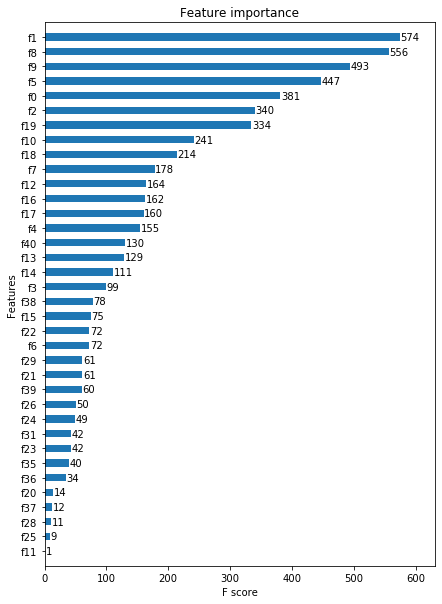

In [84]:
fig, ax = plt.subplots(1,1,figsize=(7,10))
#model_XGB.get_booster().feature_names = train_df.columns
xgboost.plot_importance(model_XGB, height=0.5, ax=ax, grid=False)
plt.show()

### D.3 LinearSVC

In [85]:
lsvc = pd.DataFrame({'features':train_features.columns, 'coefs':model_LinearSVC.coef_.ravel()}).sort_values(by='coefs')
lsvc_pos_class = lsvc[lsvc.coefs > 0].sort_values(by='coefs', ascending=False)
lsvc_neg_class = lsvc[lsvc.coefs < 0].sort_values(by='coefs', ascending=True)

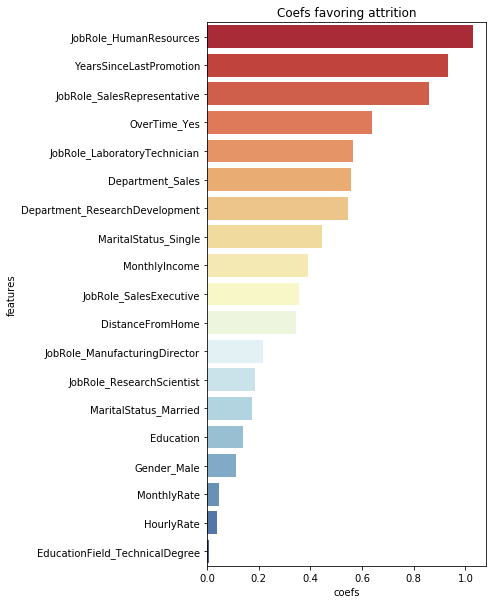

In [86]:
plt.figure(figsize=(5,10))
sb.barplot(lsvc_pos_class.coefs, lsvc_pos_class.features, palette="RdYlBu")
plt.title('Coefs favoring attrition')
plt.show()

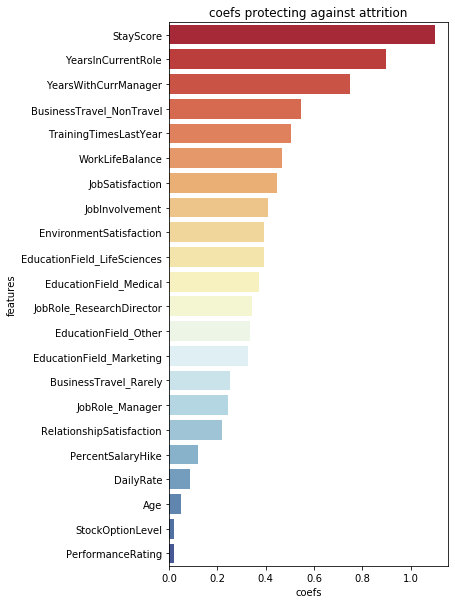

In [87]:
plt.figure(figsize=(5,10))
sb.barplot(lsvc_neg_class.coefs*-1, lsvc_neg_class.features, palette="RdYlBu")
plt.title('coefs protecting against attrition')
plt.show()

In [88]:
from mlxtend.evaluate import feature_importance_permutation

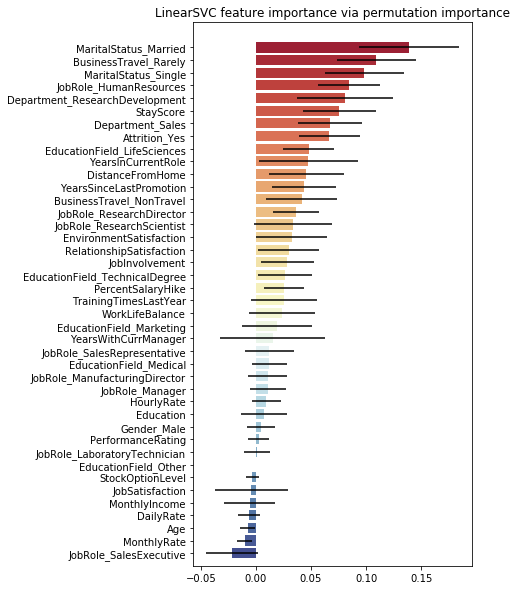

In [89]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_LinearSVC.predict, 
    X=test_features,
    y=test_labels,
    metric=metrics.f1_score,
    num_rounds=100,
    seed=1)

X=test_df
y=test_labels

#imp_vals = minmax.fit_transform(imp_vals.reshape(-1,1)).ravel()

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::1]

plt.figure(figsize=(5,10))
plt.title("LinearSVC feature importance via permutation importance")
sb.barplot(y=test_df.columns[indices], x=imp_vals[indices], xerr=std[indices], palette="RdYlBu_r")
#plt.barh(test_df.columns[indices], imp_vals[indices], xerr=std[indices])
#plt.yticks(range(X.shape[1]), test_df.columns[indices])
plt.ylim([-1, X.shape[1]])
plt.show()

### D.4 Weighted NN

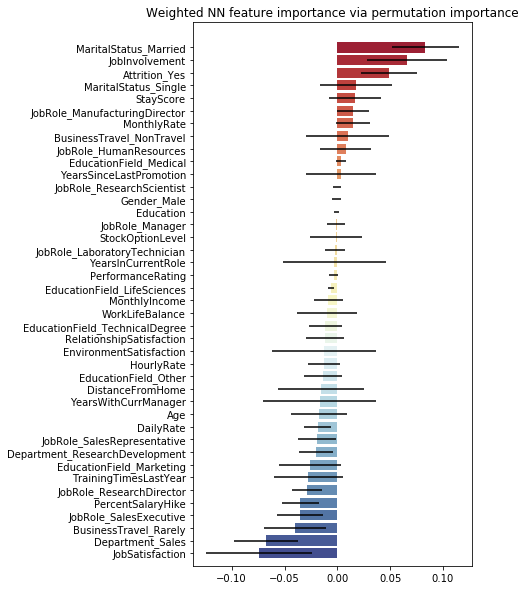

In [90]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_keras_w.predict_classes, 
    X=test_features,
    y=test_labels,
    metric=metrics.f1_score,
    num_rounds=50,
    seed=1)

X=test_df
y=test_labels

#imp_vals = minmax.fit_transform(imp_vals.reshape(-1,1)).ravel()

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::1]

plt.figure(figsize=(5,10))
plt.title("Weighted NN feature importance via permutation importance")
sb.barplot(y=test_df.columns[indices], x=imp_vals[indices], xerr=std[indices], palette="RdYlBu_r")
plt.ylim([-1, X.shape[1]])
plt.show()

## 2. Recursive Feature Selection with Stratified Kfold CV

Optimal number of features : 15


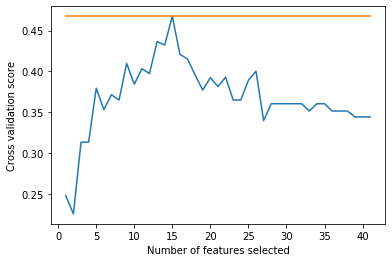

In [79]:
from sklearn.feature_selection import RFECV

# Logistic Model
rfecv = RFECV(estimator=model_logistic, step=1, cv=StratifiedKFold(5, shuffle=True, random_state=0),
              scoring='f1')
#rfecv.fit(finaldf.drop(['Attrition_Yes'], axis=1), finaldf.Attrition_Yes)
rfecv.fit(test_features, test_labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), [max(rfecv.grid_scores_) for i in range(1, len(rfecv.grid_scores_) + 1)])
plt.show()

In [80]:
l = []
for (i, feat), rank in zip(enumerate(test_df.columns), rfecv.ranking_):
    if rank == 1:
        l.append((feat, i))
print('Best ranking features:\n',l)

Best ranking features:
 [('DailyRate', 1), ('EnvironmentSatisfaction', 4), ('HourlyRate', 5), ('JobInvolvement', 6), ('MonthlyIncome', 8), ('RelationshipSatisfaction', 12), ('YearsInCurrentRole', 16), ('Attrition_Yes', 20), ('EducationField_Medical', 27), ('EducationField_TechnicalDegree', 29), ('JobRole_HumanResources', 31), ('JobRole_ResearchDirector', 35), ('JobRole_ResearchScientist', 36), ('MaritalStatus_Married', 39), ('MaritalStatus_Single', 40)]


## 3. Cluster Profile & Analysis

In [ ]:
# Kmeans
# heatmap for clusters (mean?)

# IV. Conclusions